In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import mode, norm, lognorm, gamma, skewnorm, expon, beta, weibull_min, cauchy, t, kstest

## Source

Note that we will use a single digit in square brackets (i.e., [1]), to indicate one of the sources listed here, primarily for 1-3.

1. Noseong Park and Mahmoud Mohammadi and Kshitij Gorde and Sushil Jajodia and Hongkyu Park and Youngmin Kim (2018). Data Synthesis Based on Generative Adversarial Networks. [https://www.vldb.org/pvldb/vol11/p1071-park.pdf]. VLDB

    This paper introduces table-GAN, an approach to deep modeling to create synthetic tabular data through the use of convolutional neural networks (CNNs) and generative adversarial networks (GANs). Note that it was published in the same year as the next paper on TGAN, though it is by different authors. Note that source 2 below references this paper and its tableGAN approach.
    
2. Lei Xu and Kalyan Veeramachaneni (2018). Synthesizing Tabular Data using Generative Adversarial Networks. [https://arxiv.org/abs/1811.11264]. arXiv

    This paper introduces tabular generative adversarial networks (TGANs), a precursor to the CTGAN in the next paper and similar to the previous paper but utilizing recurrent neural networks (RNNs) in place of CNNs.
     
3. Lei Xu and Maria Skoularidou and Alfredo Cuesta-Infante and Kalyan Veeramachaneni (2019). Modeling Tabular Data using Conditional GAN. [https://arxiv.org/abs/1907.00503]. arXiv

    This paper introduces conditional tabular generative adversarial networks (CTGAN), a deep learning conditional GAN that improves, according to the authors, on their approach in the previous paper by introducing a conditional generator to the architecture.

4. Emiliano De Cristofaro (2024). Synthetic Data: Methods, Use Cases, and Risks. [https://arxiv.org/abs/2303.01230]. arXiv

    This paper is a good resource for understanding synthetic data generally.

5. Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

    This dataset comes from the University of California Irvine Machine Learning Repository, is based on 1994 Census data, and allows us to classify if given individuals make more than $50,000 per year. While gleaning insights out of the dataset is not the focus of this project, we do still need a dataset to work with as we test out generating synthetic data. We partially pick this dataset because it shows up in a number of the papers referenced for this project.

6. Alec Radford and Luke Metz and Soumith Chintala (2016). Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. [https://arxiv.org/abs/1511.06434]. arXiv 
    
    This paper introduces deep convolutional generative adversarial networks (DCGAN), a GAN architecture that [1] relies on.


## Project & Introduction to Synthetic Data

My modus operandi is to start projects by finding interesting datasets and building out the other details from there. In this project, we will instead start with an application of deep learning and see if we can get it working on a tried-and-true machine learning dataset. We will try to build a deep learning model that creates synthetic data. Synthetic data is "artificially generated [data] that resemble[s] the actual data -- more precisely, having similar statistical properties" (De Cristofaro, 2024, p. 1).

Note that it is unclear at the outset of the project just how far into creating synthetic data models we will be able to get in this project. As we will see in the next section, the three research papers above that we will focus on for implementation are pretty complicated. My preference is to tackle that complexity head-on and see how far we can get, but I do want to recognize that each paper has numerous authors with terminal degrees, and this research may be part of some of the authors' theses, so I want to be careful in assuming that I may be able to recreate all of their work, even if I have their research papers to guide me. It may be that we get part of the modeling working, but we do not get a full version of the models from any of the papers. My read on the assignment is that progressing through the stages of building up synthetic data models fits with expectations, and I am really interested in tackling a project with this kind of complexity of theory and modeling, so we will see how far we can get in terms of building one of these models.

Now, back to synthetic data.

Synthetic data has been in the air lately due to its proposed use to feed even greater amounts of data into burgeoning artificial intelligence models. This use of synthetic data is focused on increasing the amount of data that is available. If we have 1,000,000 rows of data, we can use a model to learn the ins and outs of that data and then create new synthetic rows to supplement the real ones. We could also use this use case for synthetic data to re-balance classes in the data.

We can also use synthetic data to protect privacy, the use case I am interested in.

If we have a dataset that includes personally identifiable information (PII) -- names, social security numbers (SSNs) or other unique identifiers, addresses, emails, dates of birth, etc. -- our first step would be to anonymize that data. One approach here would be to develop an algorithm for assigning an anonymized unique identifier for each unique individual based on the PII. We can feed PII into the model, let the model cluster by unique individuals it identifies based on the PII, and then have the model assign the anonymized identifier to each cluster. We could then drop all PII from the dataset and replace it with the anonymized identifier.

This is a good first step in that it removes data that can identify an individual directly, but we still have a problem. Someone may be able to use, for instance, high school graduation year, high school grade point average, courses taken in high school, race and ethnicity, and gender to reverse engineer who someone is. We cannot anonymize all data, including non-PII data, to reduce this risk since we would have nothing left to run analysis on. But, we can synthesize data. Instead of supplementing real data with synthetic data to increase the number of observations in the dataset, this time we can create a dataset that is entirely made up of synthetic data, allowing us to share the synthetic dataset for analysis since it matches the real data's statistical properties but while protecting privacy since we are not releasing any rows with real data, so there is no real person to tie any row back to.

This project will focus on "[g]enerative machine models [that] learn how a dataset is generated using a probabilistic model and [that] create synthetic data by sampling from the learned distribution" (De Cristofaro, 2024, p. 2). Relying on models we learned in class, generative adversarial models (GANs) seem like the obvious choice for this use case. (See the GAN section below for a deeper dive into GANs.) The Monet-image Kaggle competition leverages CycleGANs, and CycleGANs can in a sense be thought of as autoencoders, another model that we may want to look at here. Autoencoders convert an input to a reduced latent space (encoder) and then convert that latent space back into the original space (decoder). Once we train the autoencoder, we can pass random noise as input to the latent space and let the decoder translate that back into the full input space for the encoder. In this scenario, this means we could pass random noise into the latent space input for the decoder, and the decoder would convert that to the synthetic output we are looking for, in theory.

There are risks with synthetic data when it comes to privacy. While sharing completely synthetic data provides extra layers of protection, the statistical trends in the data may be strong enough that a nefarious actor could reverse engineer real identities from the synthetic data. One example of this is any value that shows up infrequently. The synthetic data should pick up on that and recreate that value with a smaller frequency, and that can lead to many common issues when dealing with small n counts in shared datasets. One attempt to address this is l-diversity where each categorical feature must have at least l factors to try and protect against this issue (Park et al., 2018, pp. 1072-1073). 

We also need to worry about very strong correlations between features. The synthetic data will pick up on this, and, again combined with small n concerns, this broadens the information a bad actor has to try and re-identify from the synthetic data. (De Cristofaro, 2024, p. 4, Attribute Disclosure section).

Another concern is re-identification attacks where the attacker uses other sources combined with the synthetic data to re-identify individuals. Fields like SSNs or names are direct identifiers. Fields like race, ethnicity, and gender are quasi-identifiers (QIDs). Attackers can use these QIDs to supplement statistical trends in the synthetic data to piece together who an individual is (Park et al., 2018, p. 1072). We can control the synthetic data we share, but we cannot control what other dataset or outside information someone may have access to.

I do want to point out that the De Cristofaro paper that I am mostly referencing in this section calls out that synthetic data to protect privacy as we will look at it in this project is not necessarily as safe as it may at first seem, providing "little additional protection compared to anonymization techniques, with privacy-utility trade-offs being even harder to predict" (De Cristofaro, 2024, p. 5). The paper recommends looking at differential privacy as a better option on top of synthetic data. Differential privacy introduces noise into the data that is shared, muddying up what is real or not. This highlights the tension between privacy and utility of synthetic data since adding in noise to protect privacy inherently reduces the statistical accuracy of the synthetic data compared to the real data (De Cristofaro, 2024, p. 1). And, regardless of what solution we use, there really is no way to get both privacy and utility for underrepresented values or classes in the data since any upsampling to protect privacy by necessity alters the statistical accuracy of the synthetic data (De Cristofaro, 2024, p. 6).

The issues raised here are not exhaustive, but they hopefully provide an introductory sampling of the kinds of issues we are concerned with and how synthetic data attempts a response to those issues. Zooming out and acknowledging the complexities and concerns mentioned here and referenced in the cited papers, we do need to start somewhere. The goal of this project is to understand how deep learning models for synthetic data work, trying to build a model up while following along with the research papers. We need a solid foundation in synthetic data before adding in too many open issues that are yet unsolved for synthetic data modeling. The next step is to plan out how we will work with the research papers to try to build our own synthetic data model.

### Note

I had the opportunity to talk with researchers who build synthetic data generation solutions. They also caution that there are many research papers that propose solutions for generating synthetic data, but many of those are untested in production environments, so I may risk trying to recreate solutions from papers that have not been used in practice. Their general advice is to avoid GANs due to computation and sample size requirements.

That all said, I only got to speak with these researchers after completing most of this project, so we will stick with the GAN papers above. Just want to call this out here since I would have adjusted the approach had I talk with experts before getting so far into this project.


## Neural Network Background

This section covers background material that readers are likely to know having gone through this deep learning course or other supplementary information needed for understanding the research papers. We separate these summaries out to shorten the paper summaries later.

### Generative Adversarial Networks (GANs)

GANs are machine learning architectures (networks) that use competing neural networks (adversarial) that generate (generative), in this case generating synthetic data. The competing networks are the generator and discriminator. The generator takes in a noise vector as input and, initially, generates random noise. The discriminator takes in the output of the generator along with real data and distinguishes between the two, passing its labeling of real and synthetic data back to the generator. This cycle repeats again and again, each time the generator getting better at generating real-looking synthetic data and the discriminator becoming more discerning between real and synthetic data. The goal is that the generator will eventually win out and produce synthetic data that a well-refined discriminator cannot discern as different from real data. At this point, we have a generator model that we can use to produce real-enough synthetic data.

### Convolutional Neural Networks (CNNs)

CNNs are feed-forward neural networks where we apply kernels or filters -- rectangular windows -- that slide along the dimensions of the input matrices. For tabular data, we transform an input row into a square matrix, zero padding as necessary to fill out the square matrices, so we can think of the input for tabular data as appearing like an image with a width and a height and with values at each pixel. For example, if we have an input row with 13 features, we can transform that 1x13 vector into a 4x4 matrix and pad out the 2nd, 3rd, and 4th columns in the final row since the original row does not have enough features to fill those cells in the transformed matrix.

When we focused on images as inputs in a previous week's project, the CNN kernels summarized or abstracted elements of the images. If we added multiple kernels per layer, then each kernel would pick up on different aspects of the image. When we added multiple layers, each layer picked up on higher levels of abstraction. Note that in the CNN project we started with rectangular images with three channels and reduced those down with convolutional layers. In [1], we use "deconvolutions" or fractionally strided convolutions, and we then follow those with convolutions, the opposite direction of what we saw with the images in the previous project. We will go into the specifics for [1] below.

One aspect of CNNs to highlight is striding. Striding occurs when we slide a filter across a matrix but skip certain amounts at each step. For example, if we have a 10x10 input matrix and a 2x2 filter, without striding we would start with the filter in the upper-left of the matrix, calculate, and then shift the filter to the right by one. If we add a stride of 2, when we move that filter to the right, we skip a column and move to the second column to the right. A stride of three would skip two columns and jump to the third to the right.

For fractionally strided convolutions, we use strides that are less than 1. Strides greater than 1 reduce the output dimensions, so strides less than one increase the output dimensions. If we stride by 1/2, we add rows and columns of 0s between the rows and columns of the original matrix. This will double the dimensions of the input. We can then apply a convolution layer to the upsampled output with additional padding but with no pooling or striding to keep the dimensions of the upsampled output the same but to fill in the 0s. This process shows up as "deconvolutions" but is implemented with fractional striding in order to increase instead of decrease the dimensions of the input to that convolutional layer.

### Deep Convolutional GAN (DCGAN)

This model is explained in [6] and shows up in the architecture for [1]. DCGANs are GANs that use specific CNN architectures for both the generator and discriminator. Page 3 of the DCGAN paper has a summary list of the details for DCGAN that we will copy over here:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers. [Radford et al., 2016, p. 3]

### Recurrent Neural Networks (RNNs)

RNNs introduce recurrence, a deviation from feed-forward network architectures. CNNs are one example of feed-forward networks where the inputs get passed forward through the network but do not move sideways or backwards. In RNNs, we have recurrent layers that look sort of like hidden layers in other artificial neural networks but that are able to pass their output back into themselves, creating a loop in place of feed-forward hidden layers. Technically the RNN has one recurrent hidden layer, but we can think of that repeating hidden layer as unfolding into sequential hidden layers that take inputs from the previous hidden layers as well as new inputs from the tabular data. Note that the weights for the hidden recurrent layers are shared in an RNN, that being different from hidden layers in other architectures having their own separate weights.

We will cover RNNs in [2] in more detail below, but the general idea is that, for a given row, we will pass the first feature into the RNN, and then we will pass output weights from that first feature back into the RNN along with the second feature, then we will pass weights from that output back into the RNN along with the third feature, and on and on. The focus here is that we are treating features in a row like sequential inputs where each input can receive information from previous inputs. This idea of features as sequential inputs for tabular data is interesting in opening up the possibility of using RNNs to generate tabular synthetic data.

[2] also leverages long short-term memory (LSTM), an RNN strategy to address the model forgetting from sequential elements that it saw further away from the current element. For example, if we have 50 columns to generate, we may find that the RNN remembers the previous dozen or so columns, so, once we get to column 30, the model no longer factors in the first dozen columns. This means that earlier columns may not be able to inform later columns, so we are leaving information between columns on the table. LSTMs address this by adding in ways to influence how much information a layer remembers or forgets from previous layers, the goal being to keep more impactful information from further back while dropping less impactful information from more recent elements.

### Word Embeddings (do we need these?)

Only [2] references embedding vectors, but we will introduce them here in case we end up needing them. Machine learning models work with numbers, not with text, so we need a way to turn text into numbers. One approach could be to identify all the unique words in a feature -- the vocabulary for that feature -- and then one-hot encode each individual word, creating a one-hot encoded matrix per feature. Skipping over some of the cons of this approach, next we could instead create a matrix with one row per row in the base dataset and one column for each word in the combined vocabulary, and then we could put 1s for each word that shows up in a given row for a feature. A third approach could be to create a list of the vocabulary for each feature, and then we can replace each word that shows up in that feature with the index of that word in the vocabulary list.

From here, there are more complicated embedding approaches such as TFIDF, Word2Vec, and GloVe. We will not go into the specifics of these, but each has a different way of converting text into numbers.

I am surprised that word embeddings do not show up more often across all three papers. When we review the papers in detail below, we will keep an eye out for what might be going on here or if the researchers assume that implementations will handle embeddings without their needing to direct how.

### Variational Autoencoders (VAEs)

Fill me in please


## Research Paper Summaries

The three papers at the start of the notebook present different approaches to generating tabular synthetic data. All three use GANs for the generative aspect of their architectures. [1] and [2] come earlier than [3] and have slightly simpler architectures, though they still introduce layers of complexity that can be hard to sort through. [3] comes later and looks more effective than [1] and [2], but it introduces an extra layer of complexity with a conditional GAN and more complex normalization for continuous columns.

For terminology, we will refer to the model in [1] as table-GAN, in [2] as TGAN, and in [3] as CTGAN.

Note that here we are covering new info not discussed above. Each paper has some level of review of other methods for preserving privacy and utility. The papers cover many areas related to risk, exposure, and competing methods. To keep the scope down, we will focus on the core of the approaches and architectures that each paper uses and that we can try to implement ourselves.

We will save some of the details on specific architectures until closer to modeling later on since we will need to translate those details into source code at that point. We also move some portions of the research papers such as loss or evaluation strategies into separate sections below the summaries since we will need to decide how to deploy those later.

### [1] Data Synthesis Based on Generative Adversarial Networks

This paper introduces the general idea of training models to generate synthetic data and then training separate models on both the real and synthetic data to see if those second models end up with similar performance. We can also run statistical analysis on both the real and synthetic tables to confirm that they produce similar statistics. The goal is to confirm that the synthetic table is able to stand in for the real table. We will see different versions of applying this across all three papers.

table-GAN handles categorical, discrete, and continuous data but leaves out other types of data. We should keep an eye out for this as we go through preprocessing and exploratory analysis.

table-GAN consists of three artificial neural networks (ANNs): generator, discriminator, and classifier. The first two ANNs are standard in GANs, and table-GAN leverages DCGAN in particular for these two pieces. The classifier is a new addition that checks for "semantic integrity," learning what combinations of values in different columns are legitimate so we do not end up with a nonsensical combination such as generating the city of Boulder in the state of Kansas.

table-GAN includes three loss functions: 
1. The standard objective function for GANs with the minimax between the generator and discriminator with the generator minimizing this loss and the discriminator maximizing it
2. Information loss that takes the mean and standard deviation for each feature and across all the rows in that feature, making sure that synthetic rows have the same statistical properties as real rows. The goal is for this loss to be 0 for both mean and standard deviation, indicating that the discriminator may not be able to distinguish between the real and synthetic data. Note that the paper uses an exponentially weighted moving average to approximate the mean and standard deviation for each feature [1076-7].
3. Classification loss that maintains semantic integrity by predicting one feature by other features, the loss being the discrepancy between the prediction by the classifier and what is produced by the generator

The discriminator uses the standard loss, the classifier uses the classification loss, and the generator, as the most important ANN in the network, uses all three losses.

table-GAN utilizes three evaluation metrics, all detailed in the Evaluation section below:
1. Distance to the closest record (DCR)
2. Statistical comparisons
3. Comparing classification or regression performance between models trained on the synthetic and the real tables [1078]

The general table-GAN workflow is as follows:
- Convert records into square matrices, with zero padding as needed
- Train table-GAN on square matrices (see details below)
- table-GAN generates synthetic square matrices
- Flatten synthetic square matrices into records and combine into a synthetic table
- Train models and run analysis on both real and synthetic tables
- Evaluate statistics and performance on synthetic table in comparison to what we see with the real table for evaluation purposes [Park et al., 2018, p. 1074]
    
### [2] Synthesizing Tabular Data using Generative Adversarial Networks

According to this paper, it differs from [1] in:
- using RNNs instead of CNNs, using LSTM with attention in particular
- focusing on marginal distributions more than optimizing for prediction accuracy on synthetic data by minimizing cross entropy loss
- explicitly learning marginal distributions for each column by minimizing the Kullback-Leibler (KL) divergence (the KL divergence measures how different two probability distributions are) [p. 2]

Similar to the previous paper, this one calls out how tabular data can contain different data types in different features, but it explains that the distributions for each feature can be "multimodal, long-tail, and several others" [2], creating an added layer of complexity for generative modeling. Particular issues that GANs face in generating tabular synthetic data are:
1. generating discrete data
2. generating multi-modal continuous data (multimodal as in the continuous data has more than one mode or more than one value that is the most common, visually showing up as distributions with more than one peak when plotting the distribution) [p. 2]

We think of a record as having $n_c$ continuous random variables and $n_d$ discrete random variables, and one record is one sample from a joint probability distribution across the features. Each row is independent, so we do not have sequential considerations between rows. The goal is similar to what we explained in [1] above. We try to train a generative model that takes in each of the features and produces a synthetic table $T_{\text{synth}}$. We then train separate models on $T_{\text{synth}}$ and on a test table $T_{\text{test}}$ that is set aside from the real table, and we check if we get similar performance on both. This paper also introduces checking that the mutual information between two arbitrary variables in the synthetic or the real table is similar. Mutual information between two random variables is the amount of information about one random variable that you can determine based on information in the other random variable. [pp. 2-3]

The paper then moves into specifics it will explore in modeling. ANNs can effectively generate continuous distributions centered over [-1,1] using tanh and low-cardinality multinomial distributions using softmax. TGAN convert continuous variables in the real data into scalars in range [-1,1] and then into a multinomial distribution, and we convert discrete variables into multinomial distributions. [p. 3]

Next we take a look at mode-specific normalization. Numeric variables can follow a multimodal distribution. The issue with multimodal numeric variables shows up when we use tanh to normalize to the range [-1,1]. If any of the modes are near -1 or 1 or at least not near the center or 0 for tanh, we risk running into vanishing or exploding gradients during backpropagation, similar to how these gradient issues show up for S-shaped activation functions when we are working in regions not near their center. [p. 3]

So TGAN applies a workaround with Gaussian kernel density estimation (KDE) and Gaussian mixture models (GMMs). Gaussian KDE is a process by which we can imagine taking a certain window of set width, sliding that window horizontally along the actual distribution of a continuous variable, and taking an average at each step of that sliding. The Gaussian portion means points that are closer to the center of the window have more weight, and points further away have less weight similar to what we see with a Gaussian distribution. [p. 3]

GMMs are distributions that are combinations of Gaussian distributions. In this scenario, if a continuous variable has more than one mode, we can model each mode as a Gaussian distribution, and then the variable as a whole is a combination of each of those individual Gaussian distributions. So, we use GMMs to cluster each continuous random variable to estimate the number of modes. Later we can sample from the GMM. We calculate the probability that a value comes from each of the modes, and then we pick one of the modes and normalize against it. Note that the multinomial distribution we mentioned in tandem with GMMs for handling multimodal continuous variables shows up in that we can think of each mode as a factor level in the multinomial distribution. [p. 3]

With numeric variables addressed, we can pivot to categorical variables. The main issue we face here is that discrete variables are not differentiable, causing backpropagation to all apart. TGAN gets around this by one-hot encoding categorical variables and then using softmax along with adding noise to the new one-hot encoded binary variables to create differentiable units. The paper refers to this as "smoothing" categorical variables. [p. 3]

TGAN uses the standard GAN loss also used in [1] for the generator but adds the KL divergence in different ways for continuous and discrete variables. The discriminator uses conventional cross-entropy loss. [p. 4]

TGAN uses two evaluation metrics, both detailed in the Evaluation section below:
1. Machine learning efficacy
2. Pairwise mutual information

The general TGAN workflow is:
- Apply the above transformation on the real data
- Train TGAN with an LSTM RNN for the generator and a multi-layer perceptron (MLP) for the discriminator 
- Generate continuous columns in two steps, generating scalar values and weight vectors, the weight vectors indicating which mode the scalar value comes from
- Generate categorical columns in one step with a probability distribution over all the possible values

### [3] Modeling Tabular Data using Conditional GAN

Next we move on to CTGAN, the most complex of the approaches we look at here. The CTGAN paper covers much of the same ground as the previous two papers in terms of setup and background context, especially [2] since it is by some of the same authors, but this paper does introduce one more issue with source data by calling out concerns over severe imbalance in categorical columns. Aside from that, the overall setup for CTGAN is familiar to us at this point. [p. 1]

CTGAN keeps the approach in [2] while introducing several new techniques:
- Keeps mode-specific normalization as described above in [2]
- Offers architectural changes
- Addresses imbalances in categorical variables with a conditional generator and training-by-sample [p. 2]
- Introduces tabular variational autoencoders (TVAEs) that use variational autoencoders to produce tabular data, though the authors found that CTGAN outperforms TVAE [p. 2]
- Introduces a synthetic data benchmarking system that is open source and extensible [p. 2]. We may want to look at using this to evaluate different models that we build.

The issues and difficulties we address with CTGAN are similar to what we have already seen. Tabular data has discrete and continuous columns, so we use softmax and tanh in combination. Continuous columns are often non-Gaussian, so applying a tanh activation to scrunch the output into [-1,1] with a minmax function leads to vanishing gradients. Continuous columns also are often multi-modal, and vanilla GANs struggle with modeling multiple modes on 2D data. For discrete data, one issue we run into is when we again convert real discrete data to one-hot encoded vectors while producing synthetic generated discrete data as a probability distribution over all factor levels with softmax. This leads to a situation where a trivial discriminator can tell the difference between these two because of their noticeably different structures and values.

The new item since [2] is that highly imbalanced discrete columns result in mode collapse and a lack of representation for minority classes. CTGAN will propose solutions to address this issue.

We covered mode-specific normalization in [2] to handle issues with continuous variables. CTGAN also deploys mode-specific normalization using the same process as described in [2]. We point that out here since the CTGAN paper spends a good amount of real estate going over mode-specific normalization and the issue with continuous columns that it addresses.

CTGAN uses conditional generators and training-by-sample to address the issue of class imbalance in discrete features where a minority class shows up few enough times that the generator may not reliably learn to generate those values. 

First we look at the role of the conditional generator. If we resample from the real data to pick up more instances of the minority class, then the generator learns a resampled distribution, not the true distribution. We instead resample evenly across classes during training and then later recover the actual distribution during test. This means we take the same number of rows for each class during training. For each of those classes, the generator learns to generate a row conditioned on that class value for that column, hence pivoting to a conditional generator that generates full rows based on a given class value. The paper calls this a conditional generator and calls a GAN built on it a conditional GAN. [p. 4]

But adding a conditional GAN into the architecture creates a few issues: 
1. We need to create a representation for the condition and develop an input for it into the model
2. The generated rows must retain the condition we pass into the generator
3. The conditional generator must learn the real conditional distribution, meaning $P_{generated}(row|class) = P_{real}(row|class)$. We can recreate the original distribution from the evenly sampled distribution we discussed in the last paragraph by multiplying by the probability of each class showing up in each column, so $P_{generated}(row|class) P(class in real distribution) [p. 4]
 
To build out this solution, the paper proposes that we use three elements:
1. a conditional vector
2. generator loss
3. the training-by-sampling method [p. 4]
 
For the conditional vector, we one-hot encode the discrete columns. For each one-hot encoded discrete column, we can put a mask of 1 when the value for that column matches the right one-hot encoded column. We repeat this for each discrete column and then concatenate each of the mask vectors together to create the conditional vector, so we end up with, for example, a vector such as 000100100100110001000 capturing the categorical values for that row. [p. 5]

One issue with conditional vectors is that the generator can create conditional vectors with incorrect masks, vectors where we put 1s in places where they should not be. For example, for the one-hot encoded representation for a single discrete column, the generator may provide more than one 1 for that column, a result that is not realistic when we think about what the one-hot encoded vectors mean. We can add a cross entropy loss between generated and real conditional vectors so that the generator ends up learning to produce only valid conditional vectors, the new addition for the generator loss. [p. 5]

The training-by-sampling process is not totally clear to me yet. But here is my current understanding. We start by looking at the categorical features. We create a conditional vector that starts with 0s for all values for all features. We pick one feature, we look at its probability mass function (PMF), and we sample one value. We set the one-hot encoded value to 1 for that specific value in that specific feature. We then combine the one-hot encoded vector with the continuous data, and we compare that to rows in the real data. The discriminator looks at the real and generated rows and helps us to make sure the model learns what continuous values correspond with the discrete value we are working with in this iteration. We then repeat this process, selecting different discrete features and sampling from their PMFs each time to get a representative distribution of values within that feature. Over time, the generator learns how each individual feature relates to the continuous features, and then it can look in reverse to identify which values across each discrete feature correlate with the continuous values. [p. 5]

The paper talks about the process of sampling from the PMF for each discrete feature one-at-a-time and concatenating that with the remaining 0-masked one-hot encoded discrete features. The rest is my best guess at filling in how this is supposed to fit into the larger training process.

The model also tests out tabular variational autoencoders (TVAEs), though this may be one too many models for us to consider here, and the paper points out that CTGAN outperforms TVAE anyways. TVAEs are autoencoders that have probability in the latent space and that produce tabular outputs.

We discussed the new generator loss above. The last item to discuss is evaluation. It is worth noting that the CTGAN paper introduces a whole new benchmarking tool -- the [SDGym](https://github.com/sdv-dev/SDGym) -- that is open-source and available for use. The paper points out that other papers different in how they benchmark synthetic generation models, so standardizing on a benchmarking tool could provide better comparative insight between models. This tool utilizes evaluation metrics that we explain below and that were already seen in previous papers while also adding some nuance to those approaches that we have not yet seen. [p. 7]

Depending on how our implementation of evaluation metrics goes, we may want to consider using this tool across each of the different model iterations.

## Losses

GAN Loss

$$\min_{G}\max_{D}\mathbb{E}_{x\sim p_{\text{data}}(x)}[\log{D(x)}] +  \mathbb{E}_{z\sim p_{\text{z}}(z)}[1 - \log{D(G(z))}]$$

Information Loss

\begin{align*}
    L_{mean} &= || \mathbb{E}[\mathbf{f}_x]_{x\sim p_{\text{data}}(x)} - \mathbb{E}[\mathbf{f}_{G(z)}]_{z\sim p_{z}} ||_2 \\
    L_{sd} &= || \mathbb{SD}[\mathbf{f}_x]_{x\sim p_{\text{data}}(x)} - \mathbb{SD}[\mathbf{f}_{G(z)}]_{z\sim p_{z}} ||_2 \\
    L^G_{\text{info}} &= \max(0, L_{mean} - \delta_{mean}) + \max(0, L_{sd} - \delta_{sd}) \\
\end{align*}

Classification Loss

\begin{align*}
    L^C_{\text{class}} &= \mathbb{E}[|\ell(x) - C(remove(x))|]_{x \sim p_{\text{data}}(x)} \\
    L^G_{\text{class}} &= \mathbb{E}[|\ell(G(z)) - C(remove(G(z)))|]_{z \sim p(z)}
\end{align*}

## Evaluation

Distance to Closest Record (DCR) introduced in [1] calculates the Euclidean distance between a synthetic record and the closest real record. DCR = 0 leaks information since the synthetic data is the same as a real record. We apply attribute-wise normalization so that each attribute contributes equally to the distance. [Park et al., 2018, p. 1078]

Statistical comparison introduced in [1] computes per attribute metrics and compares those between real and synthetic data attributes. We want these to be very close. [Park et al., 2018, p. 1078]

Machine learning score similarity introduced in [1] trains separate classifiers or regressors on the real and synthetic tables and then checks if the F1 score for classification or the mean relative error (MRE) for regression are the same between the models trained on the real and the synthetic data. [Park et al., 2018, p. 1078]

Machine learning efficacy introduced in [2] is the same in principle as machine learning score similarity in [1]. [Xu & Veeramachaneni, 2018, p. 5]

Pairwise mutual information introduced in [2] as a way to measure TGAN's ability to capture correlations between features provides another evaluation metric. We move pairwise between columns in a table and calculate the mutual information -- how much information about one random variable you observe by looking at a second random variable -- and check that this is similar between the synthetic and the real table.

We may also look at the SDGym benchmarking tool produced by the authors of [2] and [3] and open sourced at https://github.com/sdv-dev/SDGym.



## Preprocessing and Exploratory Data Analysis (EDA)

Alright. That was a lot of text to set the background for the actual design and programming. Now we can pivot to exploring the dataset that we are working with.

This dataset has 48,842 total records, 32,561 in `adult.data` and 16,281 in `adult.test`, so a $\frac{2}{3}$ to $\frac{1}{3}$ train-test split. We will combine these and later create our own train-test split. There has been some minor preprocessing already done on the data that we are okay with, though we will explore the data for further preprocessing. We will also check if we want to keep the current train-test split or combine them and recreate our own. 

There are 14 features and 1 target. This dataset lends itself to binary classification predicting if a row makes more or less than $50,000 in income. However, since our task is generating synthetic data, our preprocessing and EDA will focus on getting the data ready for the generative models as summarized above. 

For example, distinguishing between continuous and discrete variables will be important during modeling, but we will want to slowly to figure out how each model handles these two types of data, so we should focus on selecting which continuous and discrete features to start with and which to add and in what order once we have the basics down. We will want to find a continuous column with one mode to start out with for modeling. We will then want to explore a continuous column with more than one mode, at first to see the problems that causes for modeling and then to see how mode-specific normalization may address the issue.

Pulling from the data dictionary in the `adult.names` file and from the UCI link in the Sources section above, here is a quick summary of the base features:

- `age`: numeric
- `workclass`: 8 nominal levels representing type of work such as private, federal government, local government, etc.
- `fnlwgt`: numeric combination of different Census Bureau weights; we will drop this since we are not extrapolating to population estimates
- `education`: 16 ordinal levels representing educational attainment
- `education-num`: Looks like a numeric representation of `education` feature
- `marital-status`: 7 nominal levels
- `occupation`: 14 nominal levels
- `relationship`: 6 nominal levels
- `race`: 5 nominal levels
- `sex`: binary
- `capital-gain`: numeric
- `capital-loss`: numeric
- `hours-per-week`: numeric hours worked per week
- `native-country`: 41 nominal levels
- `income`: binary target feature


In [16]:
col_names = [
    'age'
    , 'workclass'
    , 'fnlwgt'
    , 'education'
    , 'education-num'
    , 'marital-status'
    , 'occupation'
    , 'relationship'
    , 'race'
    , 'sex'
    , 'capital-gain'
    , 'capital-loss'
    , 'hours-per-week'
    , 'native-country'
    , 'income'
]

# Source CSVs have spaces after commas, so we drop them with the skipinitialspace param
df = pd.concat([
    pd.read_csv(
        './data/adult.data'
        , names=col_names
        , skipinitialspace=True
    )
    , pd.read_csv(
        './data/adult.test'
        , names=col_names
        , skipinitialspace=True
        , skiprows=1
    )
# We will drop fnlwgt here since we do not plan to use it
]).drop(columns=['fnlwgt'])

print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns\n\n')
df.info()

The dataset has 48,842 rows and 14 columns


<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   education-num   48842 non-null  int64 
 4   marital-status  48842 non-null  object
 5   occupation      48842 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  48842 non-null  object
 13  income          48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.6+ MB


No surprises here. The datatypes line up with what we are expecting to see based on the dictionary. Next we will check for nulls and invalid values.

In [4]:
print(f'There are {df.isnull().sum().sum()} nulls in the source dataset')
print()
print()

for col in df:
    print(f'{col}: {np.sort(df[col].unique()).tolist()}\n')


There are 0 nulls in the source dataset


age: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]

workclass: ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

education: ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']

education-num: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

marital-status: ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

occupation: ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handle

Most of the values look okay. We do need to clean up ?s and combine the `income` categories that differ by having a period. Aside from that, the range of values are what we expect to see for each feature, so we do not need to drop rows based on invalid values. We will test for outliers with visualizations below.

`adult.names` tells us that the curators of the data replaced unknowns with '?'s, and we see no direct nulls. We can see these show up in `workclass`, `occupation`, and `native-country`.

In an interesting turn, we are less interested in what specific factor levels mean for this project. We are concerned with their distributions and in checking that any combinations of values are valid, but, for example, while `Married-AF-spouse` seems like married to a spouse in the air force compared to `Married-civ-spouse` possibly meaning married to a civilian spouse, it actually is not important for us to clarify or confirm.

The final issue is in `income` and is that each category shows up twice: once with a period and once without, so, for example, having both '>50K.' and '>50K'.

In [17]:
print(
    f'There are {df[df.isin(['?']).any(axis=1)].shape[0]:,} rows with ?s, '
    f'{df[df.isin(['?']).any(axis=1)].shape[0]/df.shape[0]:,.3f} of the total rows in the dataset'
)
print()
print()
 
# Dropping based on the isin() condition is losing more rows than expected, so we drop this way instead
df = df[
    (df['workclass'] != '?')
    & (df['occupation'] != '?')
    & (df['native-country'] != '?')
]

# Remove the periods
df.loc[df['income'] == '<=50K.', 'income'] = '<=50K'
df.loc[df['income'] == '>50K.', 'income'] = '>50K'

print(f'The are {df.shape[0]:,} rows remaining in the dataframe')
print()
for col in df[['workclass', 'occupation', 'native-country', 'income']]:
    print(f'{col}: {np.sort(df[col].unique()).tolist()}\n')


There are 3,620 rows with ?s, 0.074 of the total rows in the dataset


The are 45,222 rows remaining in the dataframe

workclass: ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

occupation: ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']

native-country: ['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand', 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yug

Only 7% of the rows have missing values. The complexity of this project is focused on modeling, so, to avoid adding more layers of complexity here, we will drop the rows with missing values, keeping 45,222 left for us to experiment with.

Next we check out the single ordinal feature.


In [18]:
df[['education', 'education-num']].drop_duplicates().sort_values(by='education-num')


,education,education-num
224,Preschool,1
416,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
219,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


We see that `education-num` is ordinal -- matching what we see in the data dictionary -- corresponding to `education` with higher numeric values equivalent to further education. The dataset may have a numeric encoding for `education` because it is the only ordinal categorical feature. We will want to make sure to keep one of these during modeling later so we do have an ordinal feature for testing.

### Continuous Features

One of the modeling approaches we will test later is to sample from known distributions together to treat a row as a sample from a joint probability distribution. This means we need to begin identifying distributions for numeric data. We will add that step in during EDA here.

I have not found a more automated way of identifying a distribution that I feel comfortable with, and we only have four numeric features, so we can run this process by hand. The goal is to end up with a known distribution and parameters that we can sample from later.

#### Distribution Fitting

Kolmogorov-Smirnov (KS) test
H0: data comes from the specified distribution
H1: data does not come from the specified distribution


In [205]:
# Returns basic measures of central tendency
def gimme_some_averages(col):
    print(f'Mean of {col}: {np.mean(df[col]):.2f}')
    print(f'Median of {col}: {np.median(df[col])}')
    print(f'Mode of {col}: {mode(df[col])}')
    print()
    
# Fits distributions, plots PDFs of those fitted distributions, and runs and outputs KS tests
def gimme_some_distributions(col, nbins=30):
    params_expon = expon.fit(col)
    params_norm = norm.fit(col)
    params_skewnorm = skewnorm.fit(col)
    params_lognorm = lognorm.fit(col)
    params_t = t.fit(col)
    params_gamma = gamma.fit(col)
    params_beta = beta.fit(col)
    params_weibull = weibull_min.fit(col)
    params_cauchy = cauchy.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)
    
    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    plt.plot(x, norm.pdf(x, *params_norm), color='g', label='Normal')
    plt.plot(x, skewnorm.pdf(x, *params_skewnorm), color='b', label='Skewed Normal')
    plt.plot(x, lognorm.pdf(x, *params_lognorm), color='c', label='LogNormal')
    plt.plot(x, t.pdf(x, *params_t), color='m', label="Student's T")
    plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma')
    plt.plot(x, beta.pdf(x, *params_beta), color='k', label='Beta')
    plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull')
    plt.plot(x, cauchy.pdf(x, *params_cauchy), color='tab:pink', label='Cauchy')
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['norm', *[*kstest(df['age'], 'norm', params_norm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['skewnorm', *[*kstest(df['age'], 'skewnorm', params_skewnorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['lognorm', *[*kstest(df['age'], 'lognorm', params_lognorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['t', *[*kstest(df['age'], 't', params_t)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['beta', *[*kstest(df['age'], 'beta', params_beta)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['cauchy', *[*kstest(df['age'], 'cauchy', params_cauchy)]], (-1, 3)), columns=col_names)
        ], axis=0
    )
               
    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])
    
    return df_dist.sort_values(by='pvalue', ascending=False)
    

Mean of age: 38.55
Median of age: 37.0
Mode of age: ModeResult(mode=36, count=1283)



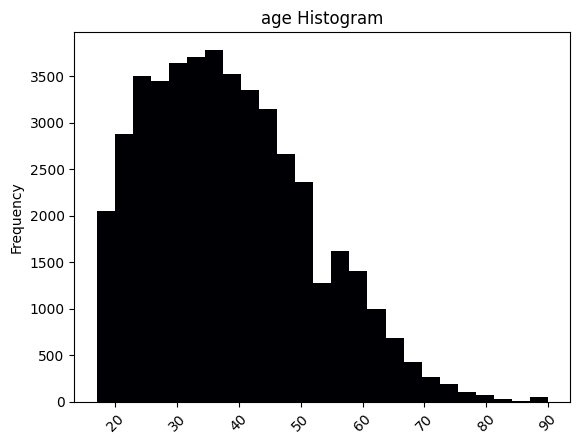

In [204]:
ax = df['age'].plot(
    kind='hist'
    , bins=25
    , title='age Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
# ax.set_yticks(ax.get_yticks())
# ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages('age')


`age` has a bit of a right skew to it. The mean and median are relatively close, and the highest age is a little over twice as much as both. Based on interests in the papers, we only see one mode, so this will be a good numeric feature to test out early before adding in more complex modeling to handle multimodal numeric data.

We have a number of distributions that appear right skewed when compared to a normal distribution. We will start by checking against the distributions in `gimme_some_distributions` above. Since we will not get a clear winner, we will also try handling outliers to see if that clarifies the underlying distribution.

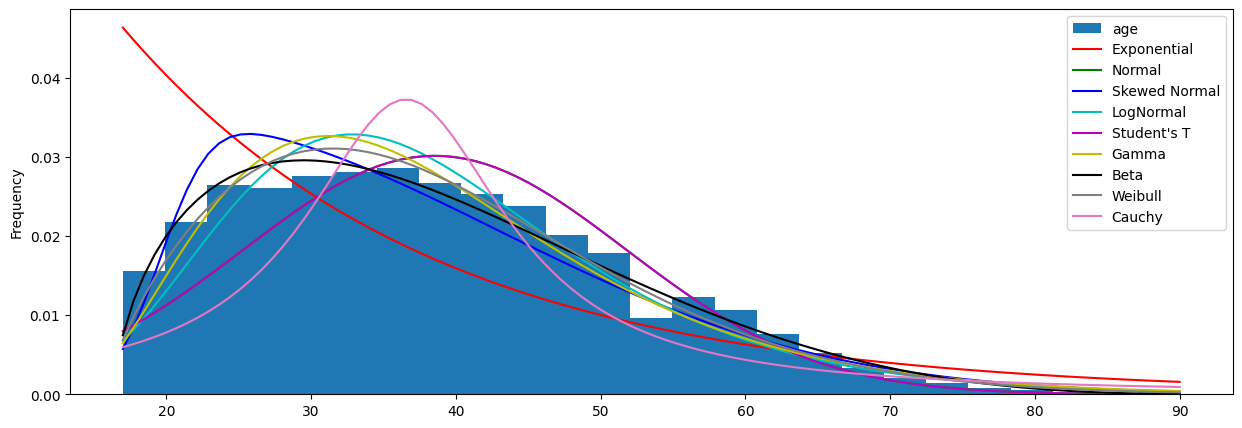

  distribution  statistic         pvalue
0         beta   0.036362   2.193863e-52
0      weibull   0.037578   6.403220e-56
0      lognorm   0.043856   5.100988e-76
0        gamma   0.048546   4.673454e-93
0            t   0.060890  3.419930e-146
0         norm   0.060896  3.192619e-146
0     skewnorm   0.069555  1.116308e-190
0        expon   0.164534   0.000000e+00
0       cauchy   0.130859   0.000000e+00




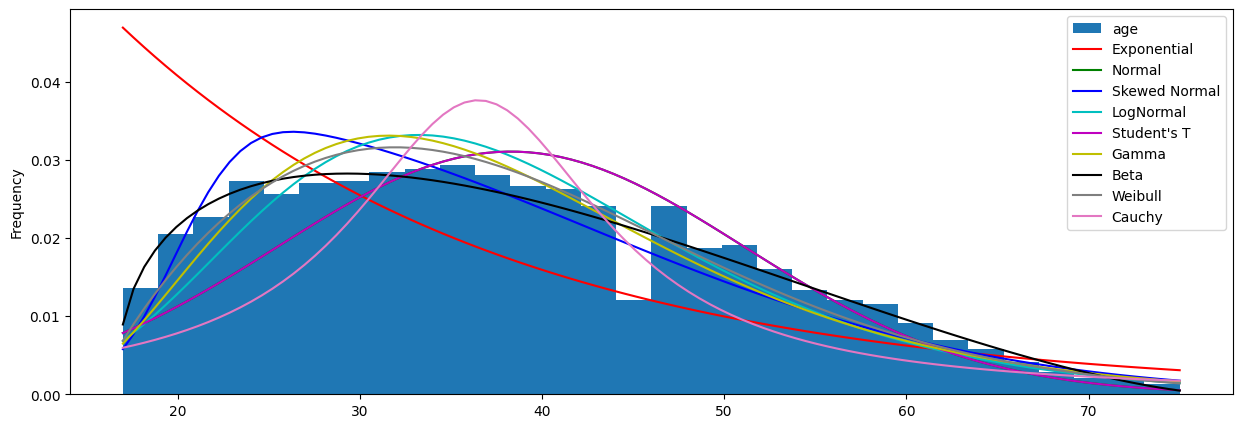

  distribution  statistic         pvalue
0         beta   0.031872   2.408832e-40
0      weibull   0.042691   4.686997e-72
0      lognorm   0.048334   2.996781e-92
0        gamma   0.053188  1.251845e-111
0            t   0.058579  2.470284e-135
0         norm   0.058582  2.409088e-135
0     skewnorm   0.073978  1.124374e-215
0        expon   0.168465   0.000000e+00
0       cauchy   0.130183   0.000000e+00


In [207]:
print(gimme_some_distributions(df['age'], 25))
print()
print()

# Removing outliers above 1.5 times the interquartile range
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr
print(gimme_some_distributions(df.loc[df['age'] < upper_limit, 'age']))



Cutting the outliers improves the KS statistic but does not change the overall distribution fitting story, so we will keep the outliers in. We reject the null hypothesis for all the KS tests, indicating that none of these distributions capture the actual data.

Visually, the beta distribution looks as good as a couple of others, and the beta distribution has the smallest KS statistic, so we can stick with this distribution for this feature. We will snag

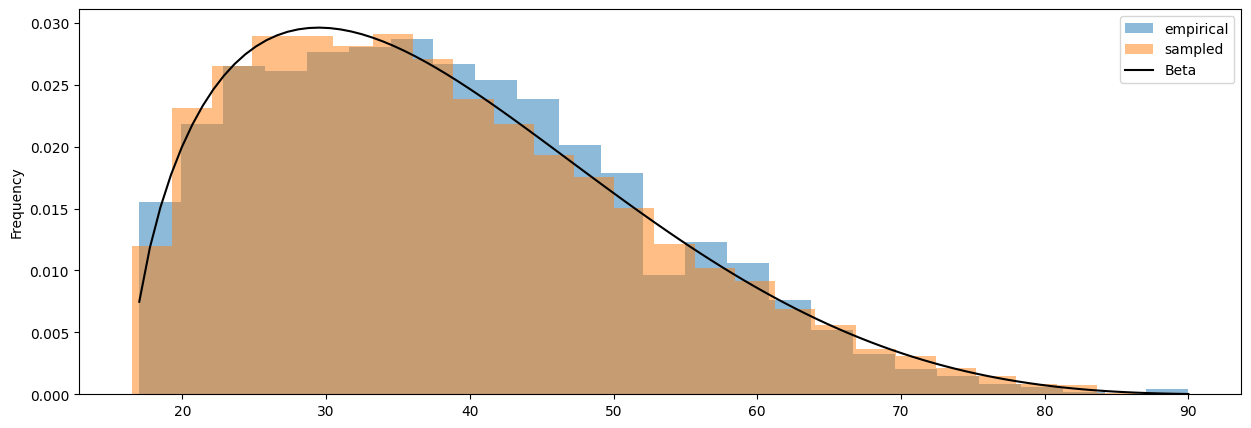

Beta distribution parameters are:
alpha=1.6420
beta=4.2078
location=16.3570
scale=78.6749


In [220]:
params_age = beta.fit(df['age'])

df['age'].plot(
    kind='hist'
    , bins=25
    , density=True
    , figsize=(15, 5)
    , alpha=0.5
    , label='empirical'
)
plt.hist(
    beta.rvs(a=params_age[0], b=params_age[1], loc=params_age[2], scale=params_age[3], size=10000)
    , bins=25
    , density=True
    , alpha=0.5
    , label='sampled'
)
xs = np.linspace(min(df['age']), max(df['age']), 100)
plt.plot(xs, beta.pdf(xs, *params_age), color='k', label='Beta')
plt.legend()
plt.show()

print(
    f'Beta distribution parameters are:\nalpha={params_age[0]:.4f}\nbeta={params_age[1]:.4f}\n'
    f'location={params_age[2]:.4f}\nscale={params_age[3]:.4f}'
)


With that, we have the info we need from `age`. Next we move onto `capital-gain`.

Mean of capital-gain: 1101.43
Median of capital-gain: 0.0
Mode of capital-gain: ModeResult(mode=0, count=41432)



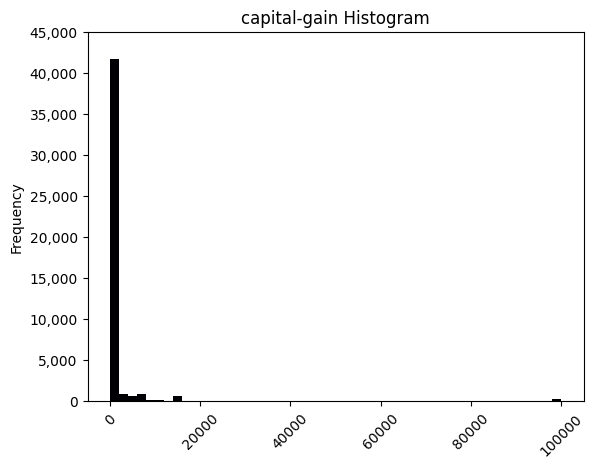

In [34]:
ax = df['capital-gain'].plot(
    kind='hist'
    , bins=50
    , title='capital-gain Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages('capital-gain')


We see some 

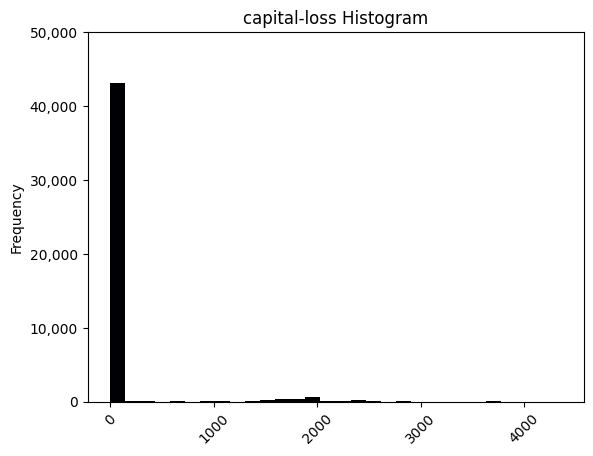

In [31]:
ax = df['capital-loss'].plot(
    kind='hist'
    , bins=30
    , title='capital-loss Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


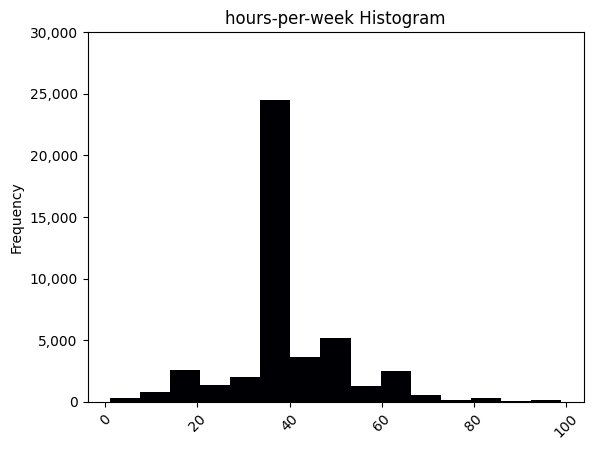

In [99]:
ax = df['hours-per-week'].plot(
    kind='hist'
    , bins=15
    , title='hours-per-week Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


### Categorical Features

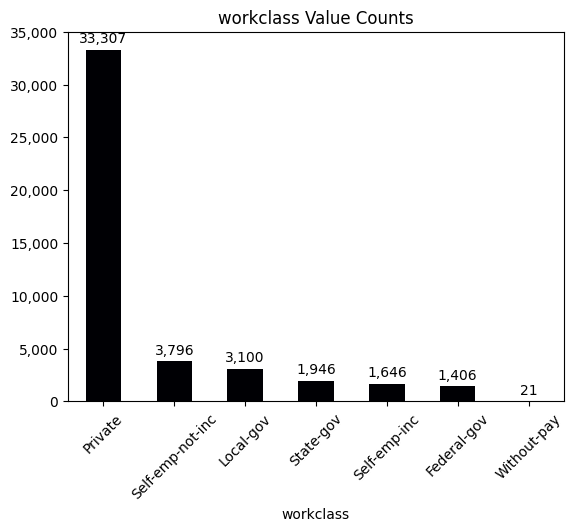

In [30]:
ax = df['workclass'].value_counts().plot(
    kind='bar'
    , title='workclass Counts'
    , rot=45
    , xlabel=None
    , cmap='magma'
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

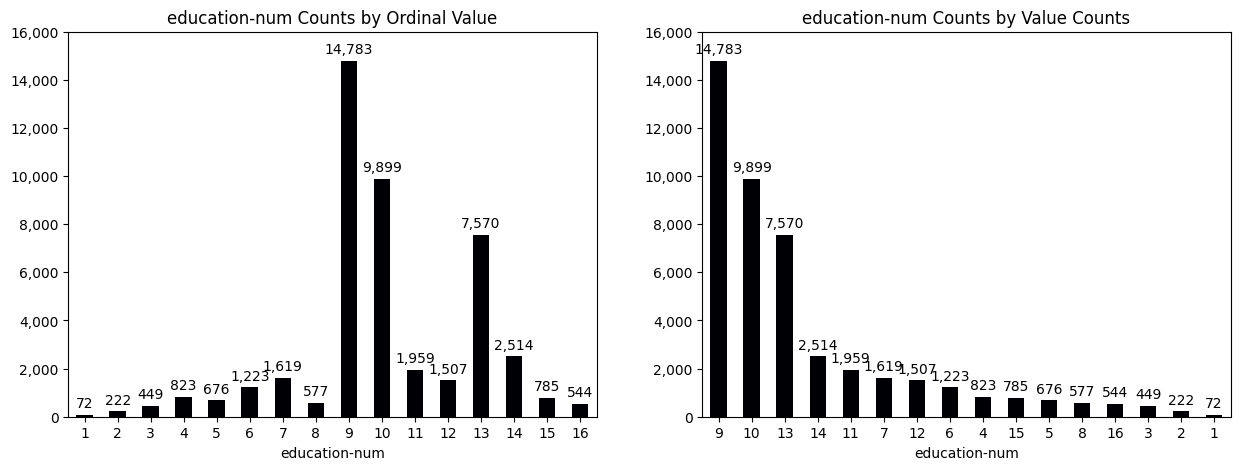

In [48]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

ax = df['education-num'].value_counts().sort_index().plot(
    kind='bar'
    , title='education-num Counts by Ordinal Value'
    , rot=0
    , xlabel=None
    , cmap='magma'
    , ax=axes[0]
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


ax = df['education-num'].value_counts().plot(
    kind='bar'
    , title='education-num Counts by Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
    , ax=axes[1]
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

plt.show()
    

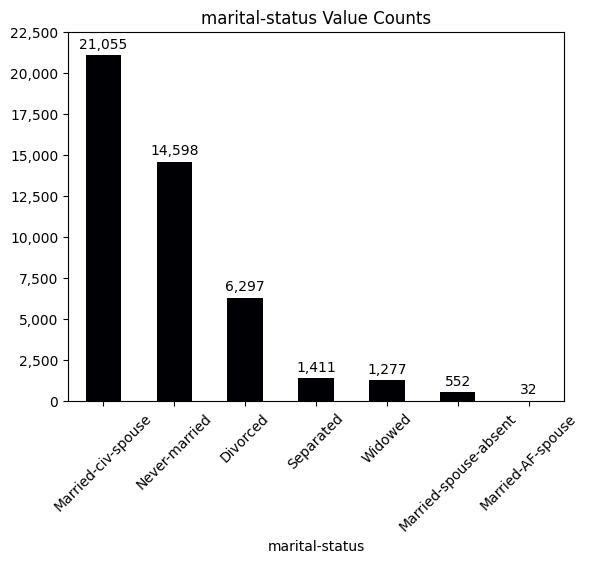

In [49]:
ax = df['marital-status'].value_counts().plot(
    kind='bar'
    , title='marital-status Counts'
    , rot=45
    , xlabel=None
    , cmap='magma'
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

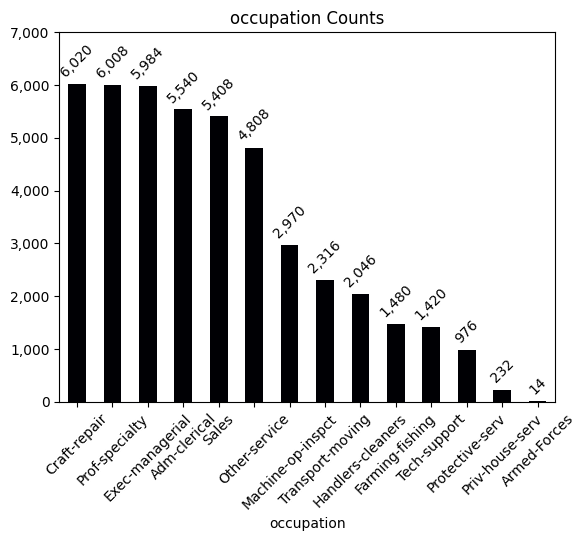

In [56]:
ax = df['occupation'].value_counts().plot(
    kind='bar'
    , title='occupation Counts'
    , rot=45
    , xlabel=None
    , cmap='magma'
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
    , rotation=45
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

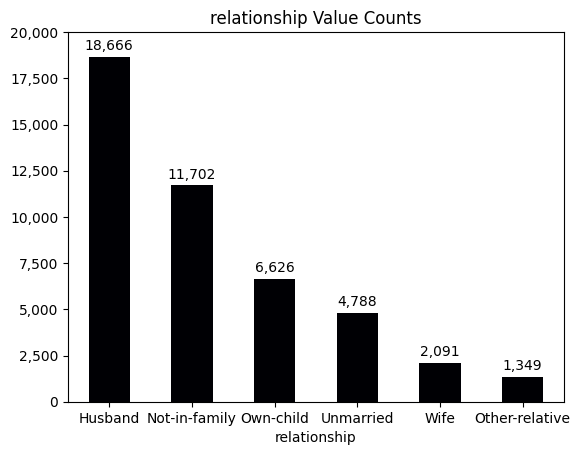

In [24]:
ax = df['relationship'].value_counts().plot(
    kind='bar'
    , title='relationship Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

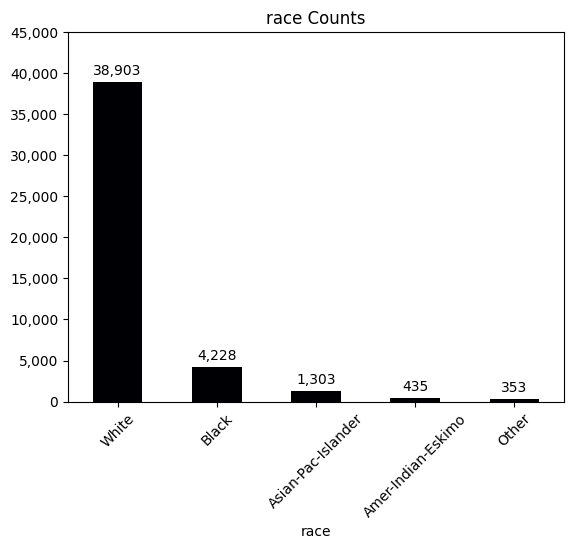

In [58]:
ax = df['race'].value_counts().plot(
    kind='bar'
    , title='race Counts'
    , rot=45
    , xlabel=None
    , cmap='magma'
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

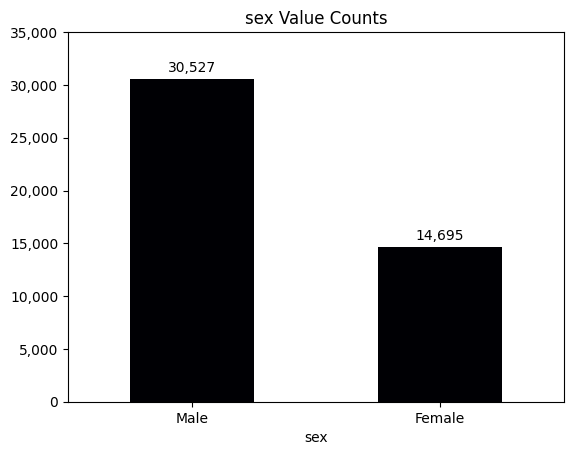

In [26]:
ax = df['sex'].value_counts().plot(
    kind='bar'
    , title='sex Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

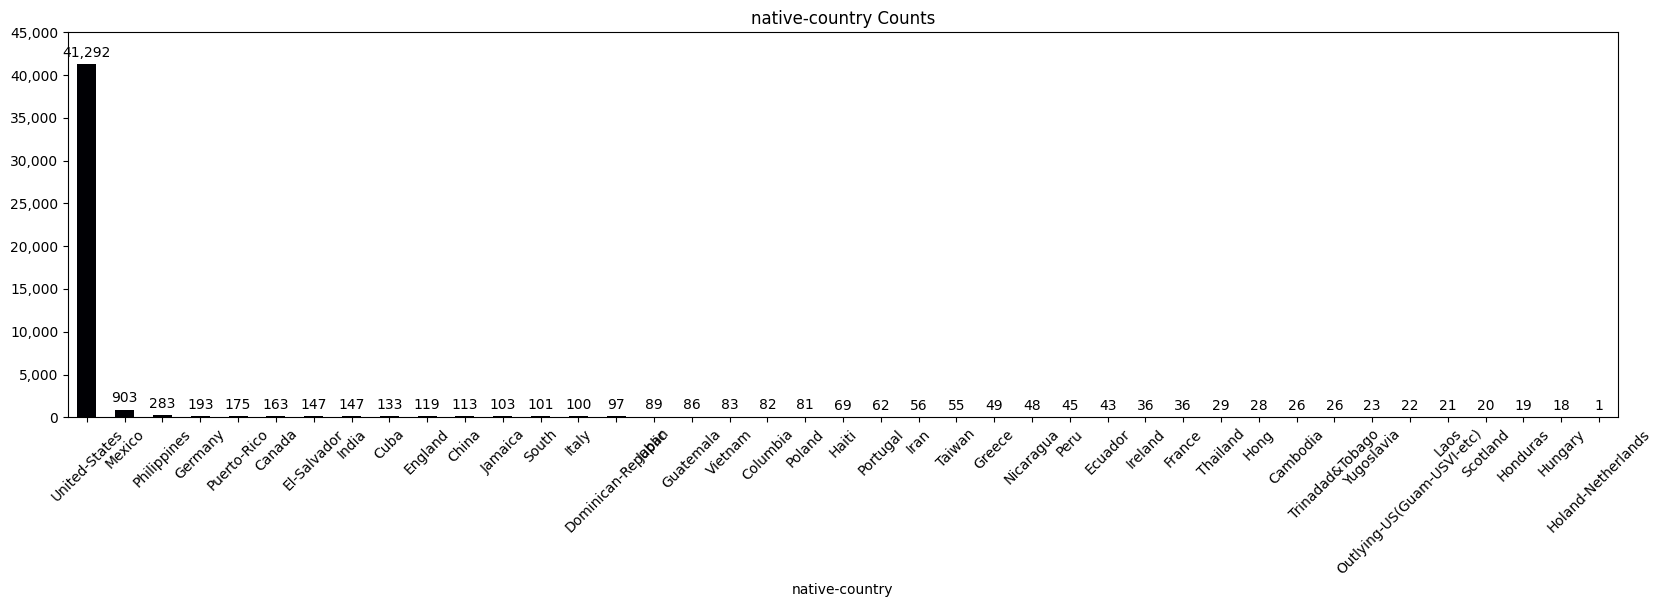

In [63]:
ax = df['native-country'].value_counts().plot(
    kind='bar'
    , title='native-country Counts'
    , rot=45
    , xlabel=None
    , cmap='magma'
    , figsize=(20, 5)
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

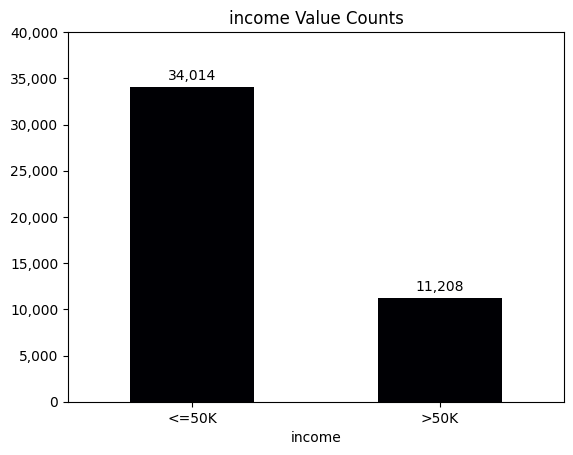

In [28]:
ax = df['income'].value_counts().plot(
    kind='bar'
    , title='income Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);
    

## References

Academic papers (core to project)
- https://arxiv.org/abs/1907.00503 (Modeling Tabular Data using Conditional GAN)
- https://arxiv.org/abs/1811.11264 (Synthesizing Tabular Data using Generative Adversarial Networks)
- https://www.vldb.org/pvldb/vol11/p1071-park.pdf (Data Synthesis based on Generative Adversarial Networks)
- https://arxiv.org/abs/2303.01230v3 (Synthetic Data: Methods, Use Cases, and Risks)

Academic papers (references for project)
- https://www2.stat.duke.edu/~jerry/Papers/jos03.pdf (Multiple Imputation for Statistical Disclosure Limitation)
- https://www2.stat.duke.edu/~jerry/Papers/sm04.pdf (Simultaneous Use of Multiple Imputation for Missing Data and Disclosure Limitation)
- https://dl.acm.org/doi/10.1145/3636424 (A Survey of Generative Adversarial Networks for Synthesizing Structured Electronic Health Records)
- https://arxiv.org/abs/1609.05473 (SeqGAN: Sequence Generative Adversarial Nets with Policy Gradient)
- https://arxiv.org/abs/1611.04051 (GANs for Sequences of Discrete Elements with the Gumbel-softmax Distribution)
- https://arxiv.org/abs/1810.06640 (Adversarial Text Generation Without Reinforcement Learning)
- https://arxiv.org/abs/2403.04190v1 (Generative AI for Synthetic Data Generation: Methods, Challenges, and the Future)
- https://arxiv.org/abs/1511.06434 (Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks)

Web articles
- https://medium.com/@aldolamberti/synthetic-data-101-synthetic-data-vs-real-dummy-data-237d790433a9
- https://machinelearningmastery.com/mostly-generate-synethetic-data-machine-learning-why/
- https://towardsdatascience.com/generative-ai-synthetic-data-generation-with-gans-using-pytorch-2e4dde8a17dd
- https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-1-2b886c8cab10
- https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-3-non-rl-methods-70d1be02350b
- https://towardsdatascience.com/how-to-generate-tabular-data-using-ctgans-9386e45836a6
- https://medium.com/analytics-vidhya/a-step-by-step-guide-to-generate-tabular-synthetic-dataset-with-gans-d55fc373c8db
- https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf
- https://www.geeksforgeeks.org/gaussian-mixture-model/
- https://ocw.mit.edu/courses/18-409-algorithmic-aspects-of-machine-learning-spring-2015/e339520c4069ca5e785b29a3c604470e_MIT18_409S15_chapp6.pdf
- https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
- https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

Source code
- https://github.com/sdv-dev/TGAN
- https://github.com/sdv-dev/CTGAN

Videos
- https://www.youtube.com/watch?v=yujdA46HKwA (GANs for Tabular Synthetic Data Generation)
- https://www.youtube.com/watch?v=Ei0klF38CNs (Synthetic data generation with CTGAN)
- https://www.youtube.com/watch?v=ROLugVqjf00 (Generation of Synthetic Financial Time Series with GANs - Casper Hogenboom)
- https://www.youtube.com/watch?v=HIusawrGBN4 (What is Synthetic Data? No, It's Not "Fake" Data)
- https://www.youtube.com/watch?v=FLTWjkx0kWE (Generate Synthetic Tabular Data with GANs)
- https://www.youtube.com/watch?v=zC3_kM9Qwo0 (QuantUniversity Summer School 2020 | Generating Synthetic Data with (GANs))
